In [1]:
packages <- c(
  "tuneR",      # WAV file processing
  "fda.usc",    # Functional data processing and classification
  "plot3D",     # For 3D plotting
  "mclust",     # For ARI
  "caret"       # For confusion matrix
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}
set.seed(42)

Warning message:
"package 'tuneR' was built under R version 4.3.3"
Warning message:
"package 'fda.usc' was built under R version 4.3.3"
Loading required package: fda

Warning message:
"package 'fda' was built under R version 4.3.3"
Loading required package: splines

Loading required package: fds

Warning message:
"package 'fds' was built under R version 4.3.3"
Loading required package: rainbow

Warning message:
"package 'rainbow' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: pcaPP

Warning message:
"package 'pcaPP' was built under R version 4.3.3"
Loading required package: RCurl

Warning message:
"package 'RCurl' was built under R version 4.3.3"
Loading required package: deSolve

Warning message:
"package 'deSolve' was built under R version 4.3.3"

Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-0. For overview t

### Prepare dataset filepaths

In [2]:
data_dir <- "SpeechCommands"
# When testing is TRUE, validation dataset is used for training
# When testing is FALSE, training dataset is used for training
testing <- FALSE

train_paths <- file.path(
  data_dir, readLines(file.path(data_dir, "train.txt"))
)
val_paths <- file.path(
  data_dir, readLines(file.path(data_dir, "val.txt"))
)
test_paths <- file.path(
  data_dir, readLines(file.path(data_dir, "test.txt"))
)

if (testing) {
  train_paths <- val_paths
} else {
  # Merge test and validation datasets
  test_paths <- c(test_paths, val_paths)
}

sample_count <- data.frame(
  Subset = c("Train", "Test"),
  Utterances = c(length(train_paths), length(test_paths))
)

sample_count

Subset,Utterances
<chr>,<int>
Train,28501
Test,7127


### Load training and testing sets
* Read signal from file
* Center signal
* Create log periodogram
* Interpolate onto a coarser grid
* Create fdata object

In [3]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 512)
  log_pgram <- approx(
    x = freqs,
    y = log_pgram,
    xout = reduced_freqs
  )$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

train <- load_dataset(train_paths)
test <- load_dataset(test_paths)

class_distribution <- data.frame(
  Class = levels(train$labels),
  Train = as.vector(table(train$labels)),
  Test = as.vector(table(test$labels))
)
cat("Class Distribution Summary\n")
print(class_distribution, row.names = FALSE)

Class Distribution Summary
 Class Train Test
  zero  3019  737
   one  2813  679
   two  2825  700
 three  2704  698
  four  2688  715
  five  2982  745
   six  2876  722
 seven  2941  727
 eight  2735  694
  nine  2918  710


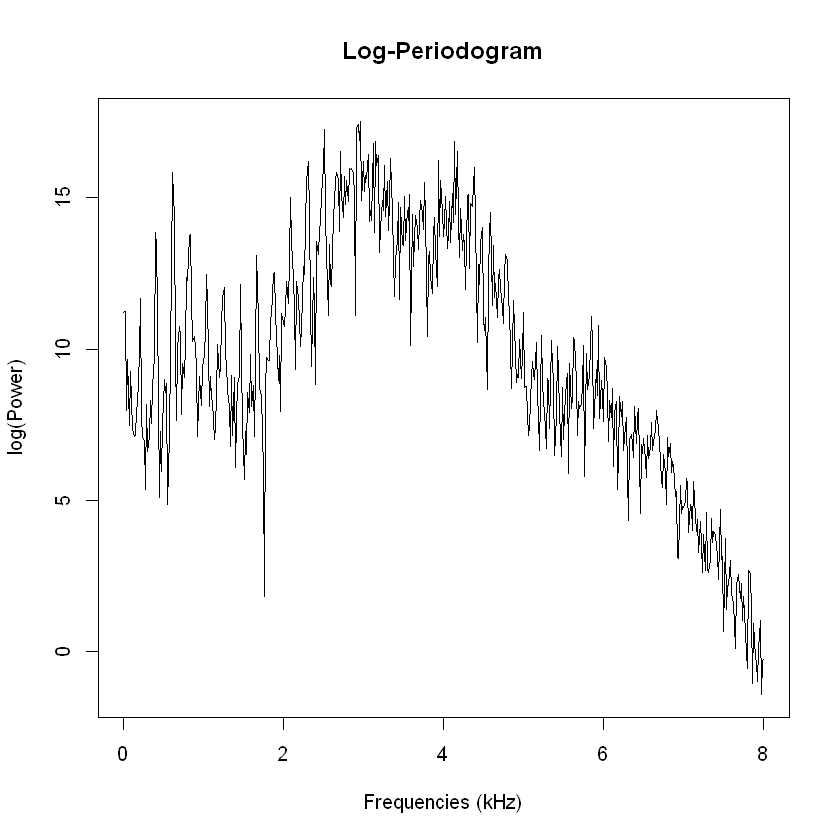

In [4]:
num_samples <- 1
plot(
  train$data[1:num_samples, ],
  main = "Log-Periodogram"
)

### Find optimal smoothing parameters with Nadaraya-Watson

Optimal smoothing parameter: 0.03687551

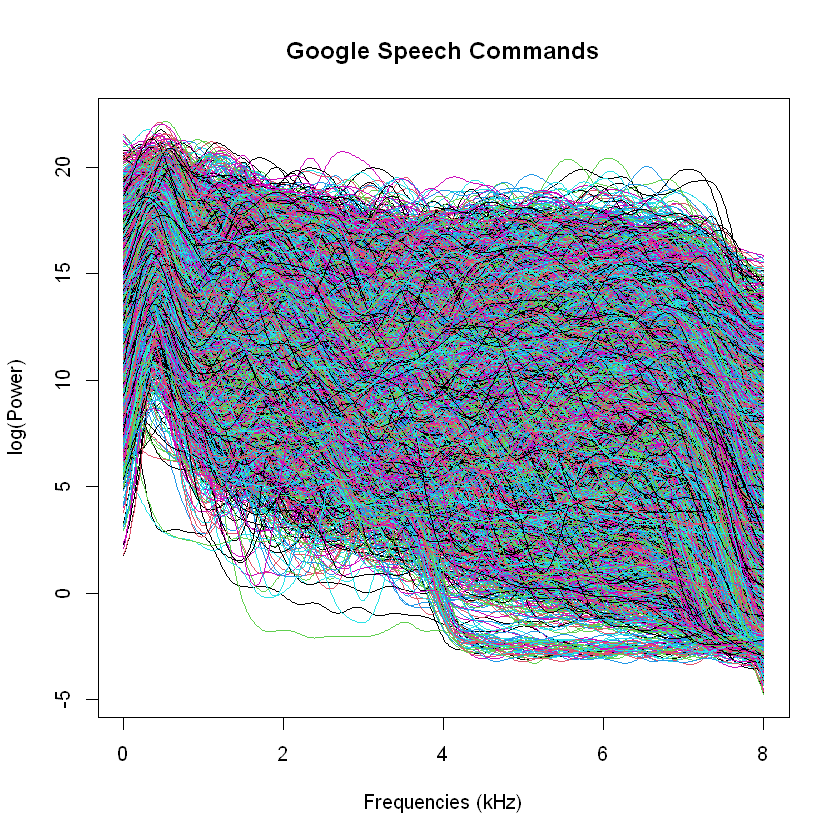

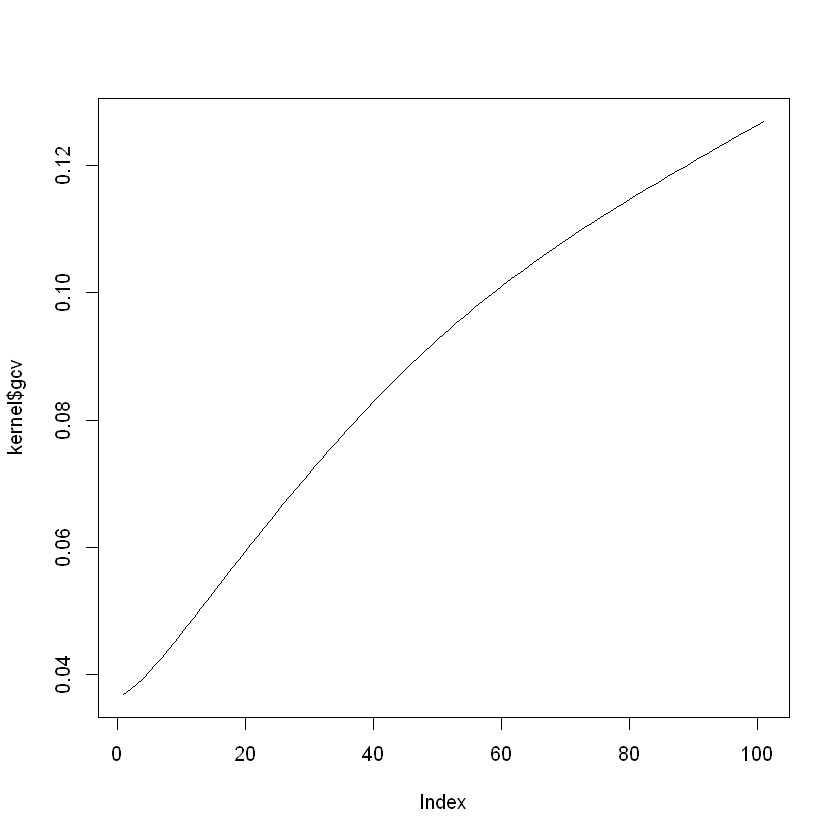

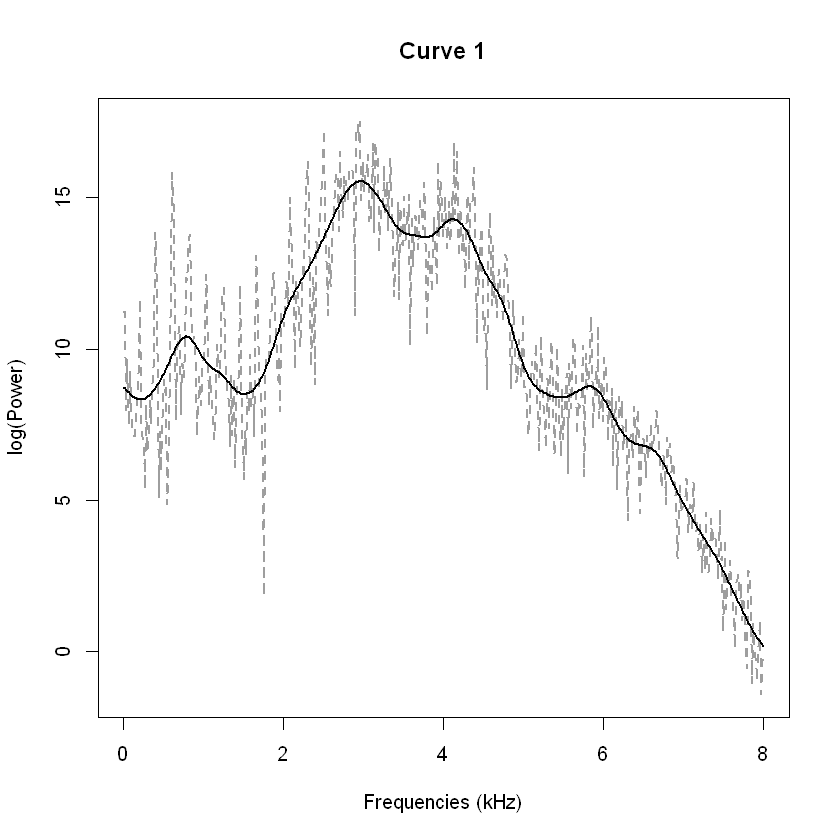

In [5]:
kernel <- fda.usc::optim.np(
  train$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
cat("Optimal smoothing parameter:", kernel$gcv.opt)

train$smooth <- kernel$fdata.est
plot(train$smooth)
plot(kernel$gcv, type = "l")

index <- 1
plot(
  train$data[index, ],
  main = paste("Curve", index),
  lty = 2, lwd = 2, col = 8
)
lines(train$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Apply smoothing to the test set

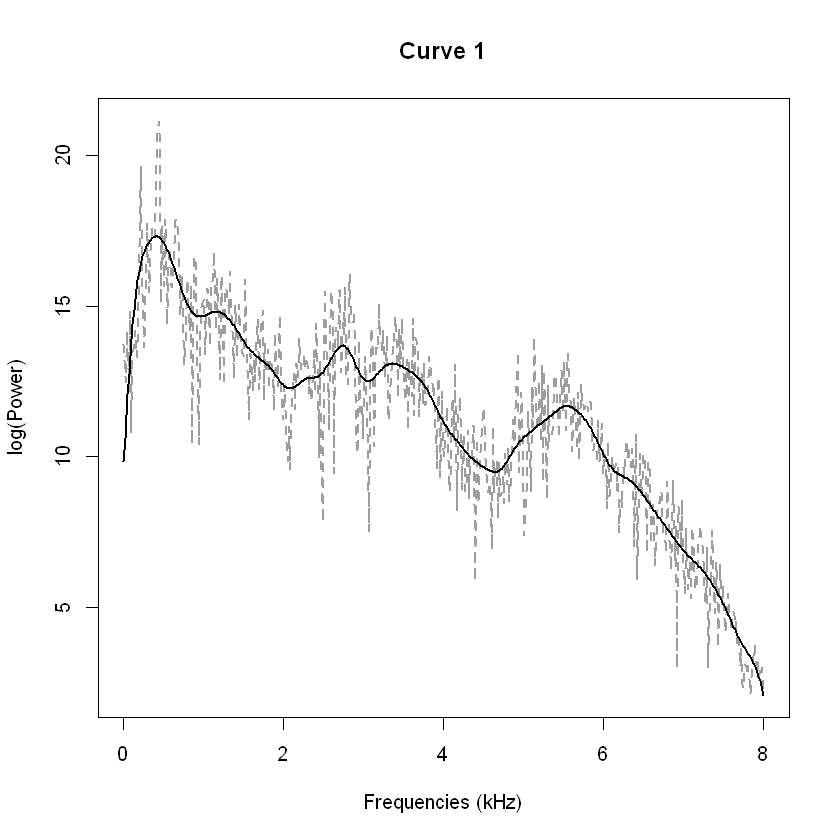

In [6]:
# Create smoothing matrix using the same grid as train data
# Apply the smoothing to the test data
s <- fda.usc::S.NW(test$data$argvals, h = kernel$h.opt)
smoothed_matrix <- test$data$data %*% s
test$smooth <- fda.usc::fdata(
  smoothed_matrix,
  argvals = test$data$argvals,
  rangeval = test$data$rangeval,
  names = test$data$names
)

index <- 1
plot(
  test$data[index, ],
  main = paste("Curve", index),
  lty = 2, lwd = 2, col = 8
)
lines(test$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Mean curve plots

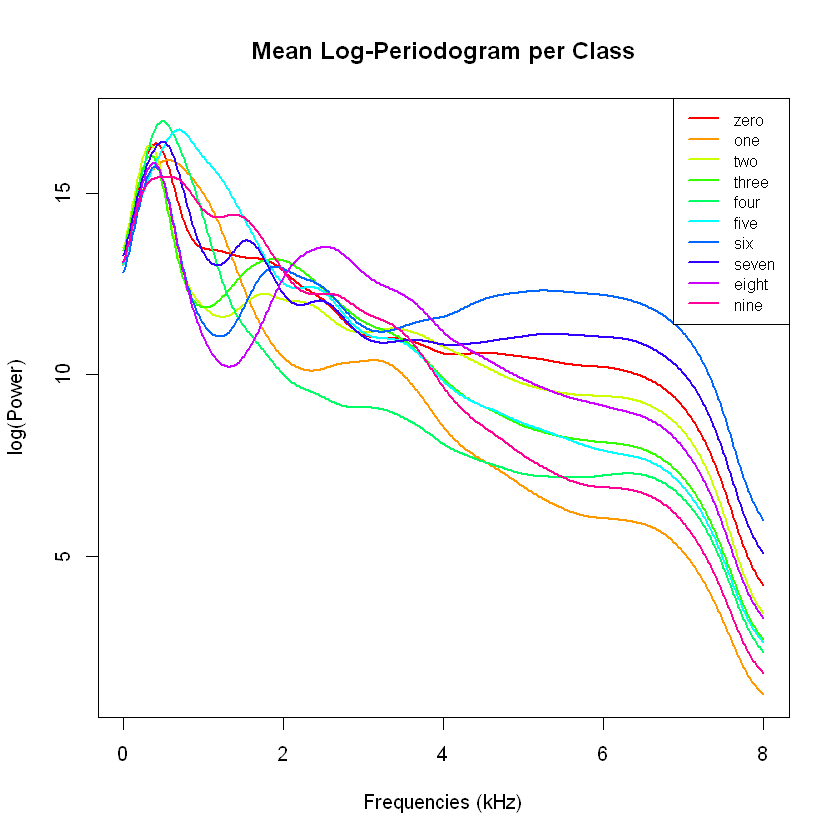

In [7]:
class_labels <- levels(train$labels)
num_classes <- length(class_labels)
palette <- rainbow(num_classes)

# Compute mean curves for each class
mean_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  func.mean(train$smooth[idx, ])
})

# Plot the first mean curve
plot(
  mean_curves[[1]],
  main = "Mean Log-Periodogram per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_curves, function(x) range(x$data)))
)

# Add the rest of the mean curves
for (i in 2:num_classes) {
  lines(mean_curves[[i]], col = palette[i], lwd = 2)
}
legend(
  "topright",
  legend = class_labels,
  col = palette,
  lwd = 2, cex = 0.8
)

### Derivative curve plots (velocity and accelaration)

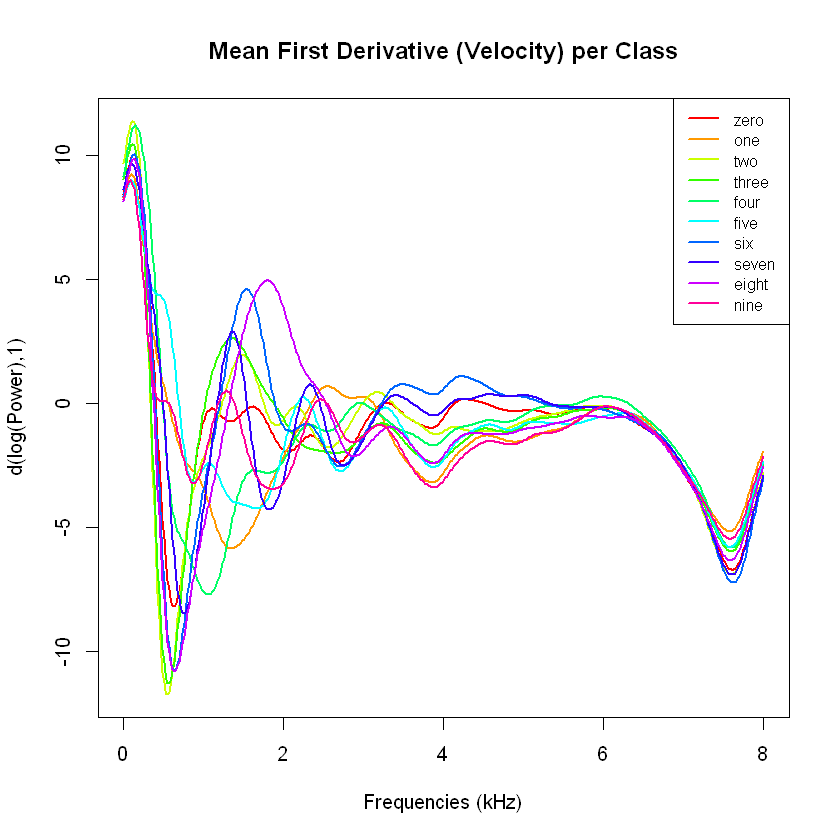

In [8]:
mean_deriv1_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv1 <- fdata.deriv(train$smooth[idx, ], nderiv = 1)
  func.mean(deriv1)
})

plot(
  mean_deriv1_curves[[1]],
  main = "Mean First Derivative (Velocity) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(
    sapply(mean_deriv1_curves, function(x) range(x$data))
  )
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv1_curves[[i]], col = palette[i], lwd = 2)
}
legend(
  "topright",
  legend = class_labels,
  col = palette,
  lwd = 2, cex = 0.8
)

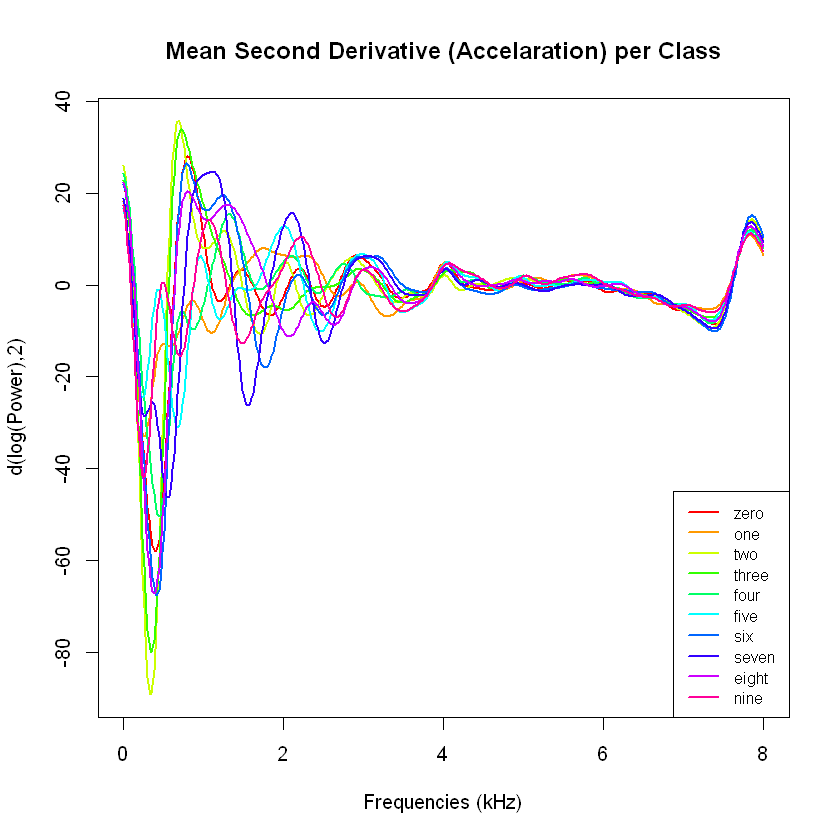

In [9]:
mean_deriv2_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv2 <- fdata.deriv(train$smooth[idx, ], nderiv = 2)
  func.mean(deriv2)
})

plot(
  mean_deriv2_curves[[1]],
  main = "Mean Second Derivative (Accelaration) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(
    sapply(mean_deriv2_curves, function(x) range(x$data))
  )
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv2_curves[[i]], col = palette[i], lwd = 2)
}
legend(
  "bottomright",
  legend = class_labels,
  col = palette,
  lwd = 2, cex = 0.8
)

### Covariance plots

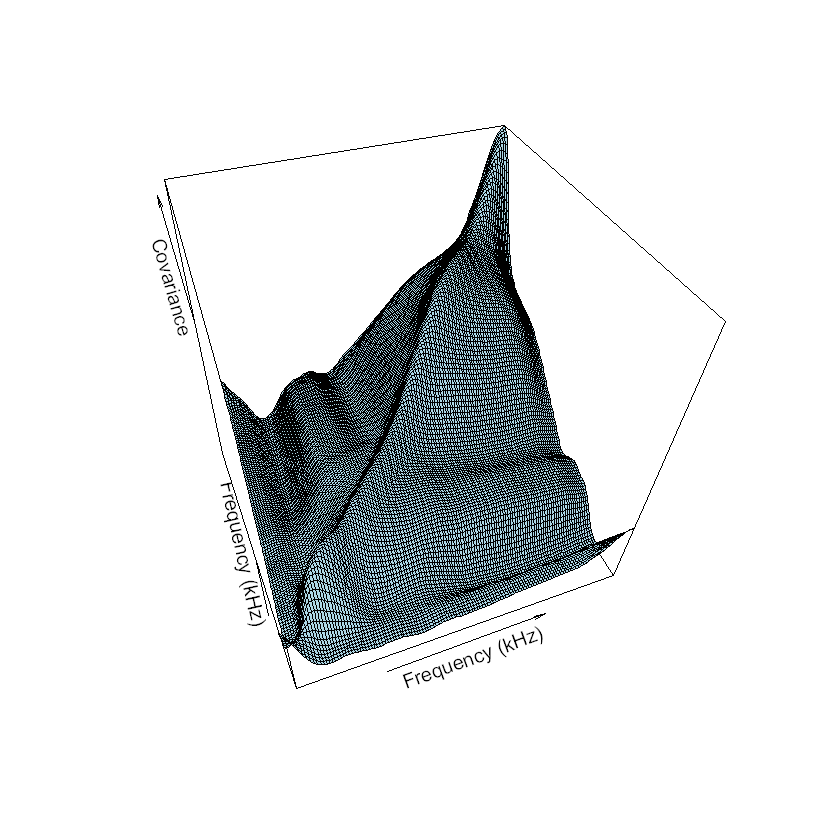

In [10]:
cov_matrix <- cov(train$smooth$data)
idx <- seq(1, ncol(cov_matrix), by = 4)
coarse_cov_matrix <- cov_matrix[idx, idx]
freqs <- train$smooth$argvals
freqs_coarse <- freqs[idx]

persp3D(
  x = freqs_coarse,
  y = freqs_coarse,
  z = coarse_cov_matrix,
  col = "lightblue", border = "black",
  xlab = "Frequency (kHz)",
  ylab = "Frequency (kHz)",
  zlab = "Covariance",
  phi = 45, theta = -20
)

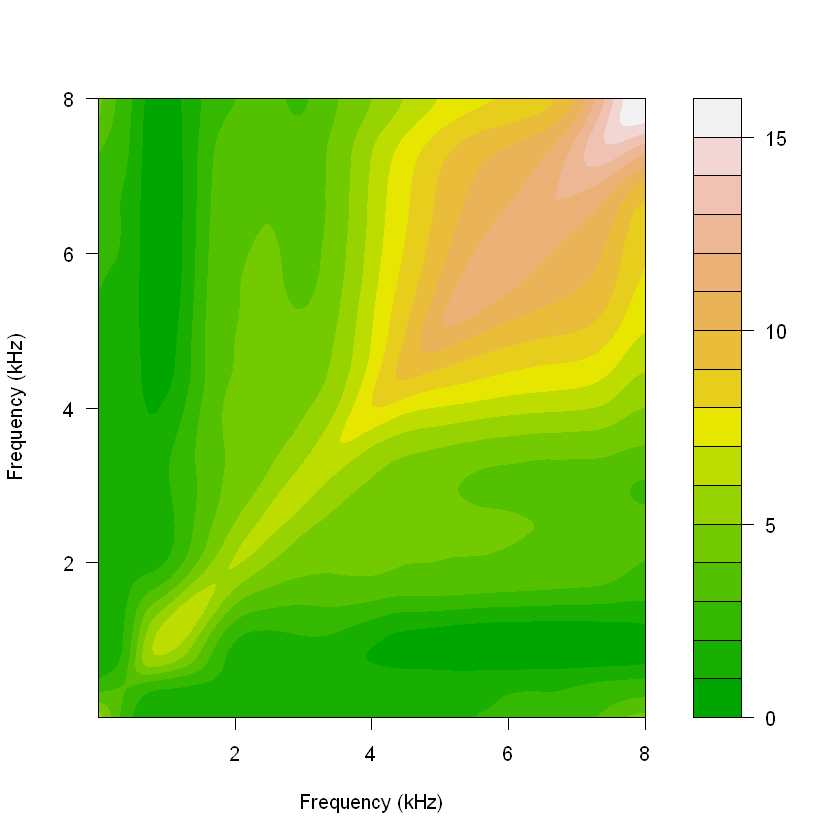

In [11]:
filled.contour(
  freqs, freqs, cov_matrix,
  color.palette = terrain.colors,
  ylab = "Frequency (kHz)",
  xlab = "Frequency (kHz)",
)

### K-means clustering

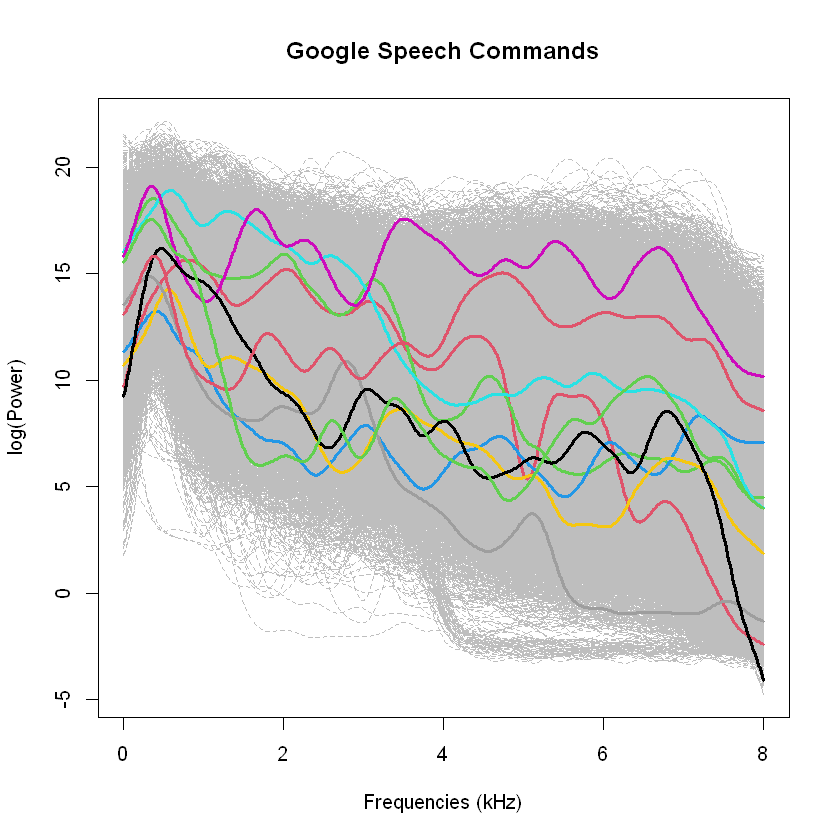

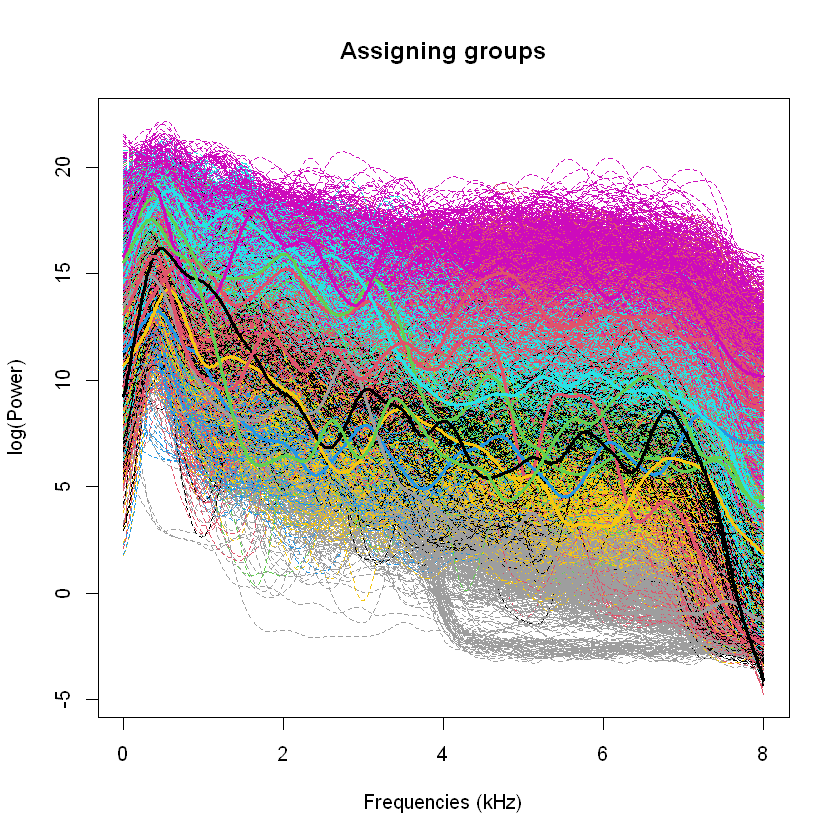

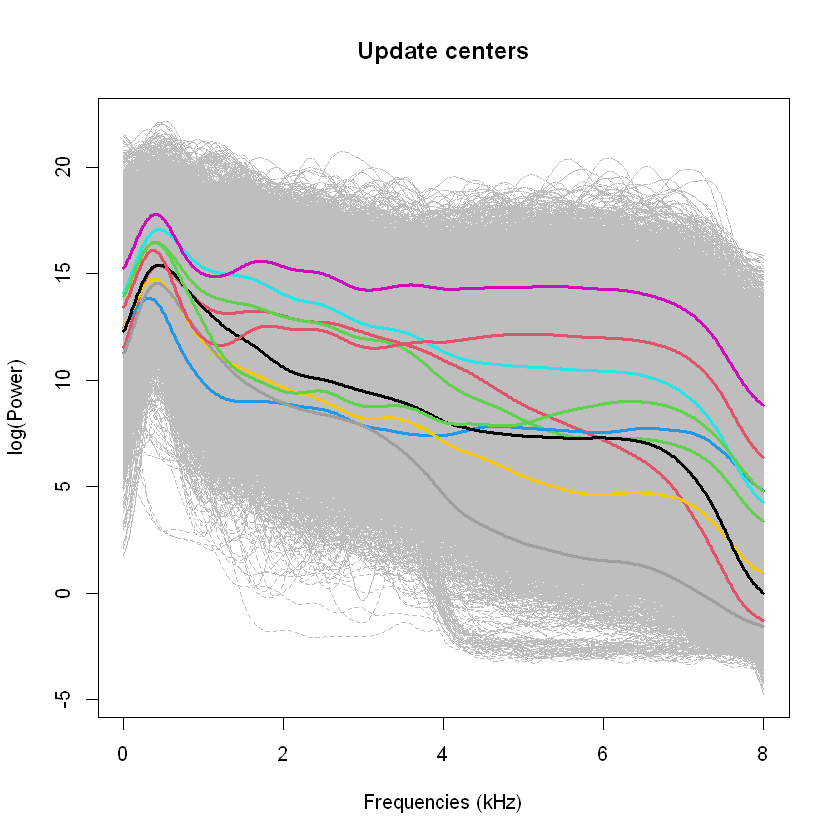

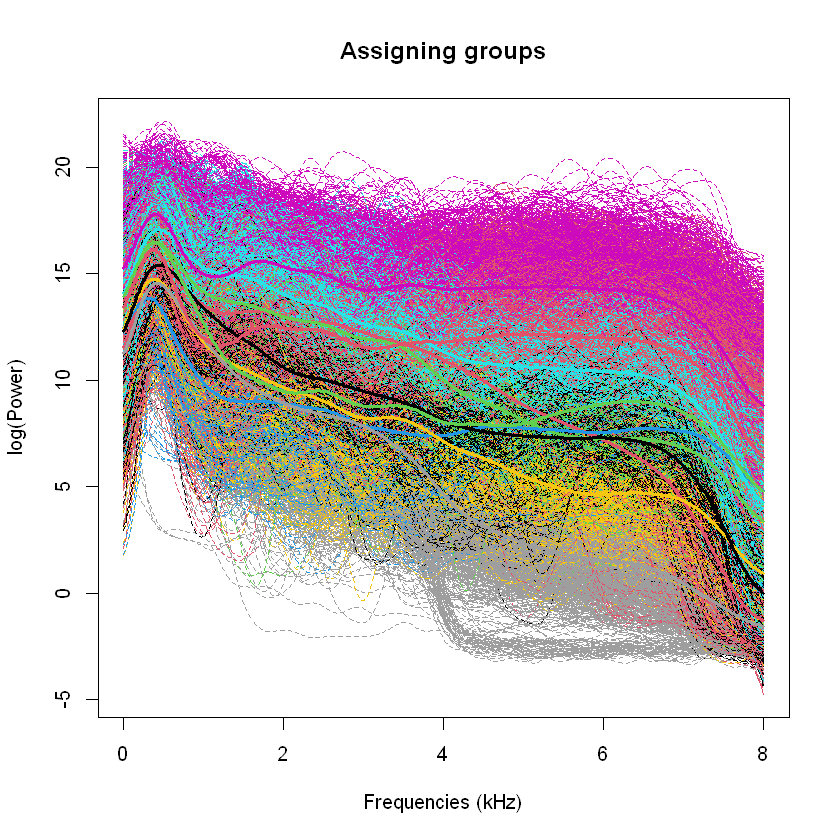

Cluster Sizes:

   1    2    3    4    5    6    7    8    9   10 
2308 4452  633 4632 1673 2500  929 4234 6185  955 
Contingency Table (True Class vs Cluster):
       Cluster
True       1    2    3    4    5    6    7    8    9   10
  zero   147  311   85  705  292  138   55  357  860   69
  one    300  541   41  272   30  474  228  810   30   87
  two    170  347   91  313  181  297   66  334  907  119
  three  290  657   59  444  108  335  100  338  333   40
  four    50  248   98  286   44  382  176  843  186  375
  five   301  658   24  993   82  194   68  569   60   33
  six     73   79   73  175  387   53   17  117 1840   62
  seven  108  196   68  597  356   98   32  282 1098  106
  eight  379  535   71  258  134  211   63  177  851   56
  nine   490  880   23  589   59  318  124  407   20    8
Adjusted Rand Index (ARI): 0.0638


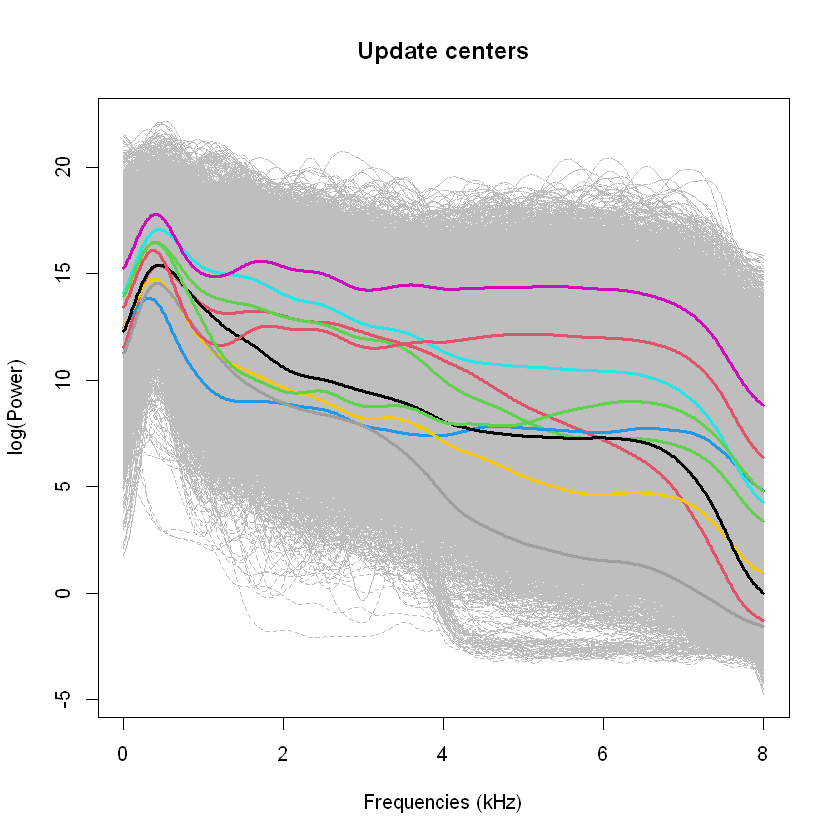

In [12]:
kmeans <- fda.usc::kmeans.fd(train$smooth, ncl = 10)
cat("Cluster Sizes:\n")
print(table(kmeans$cluster))

cat("Contingency Table (True Class vs Cluster):\n")
print(table(True = train$labels, Cluster = kmeans$cluster))

ari <- adjustedRandIndex(train$labels, kmeans$cluster)
cat(sprintf("Adjusted Rand Index (ARI): %.4f\n", ari))

### SVD

Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdrecon):
"Please assign column name for the data matrix."


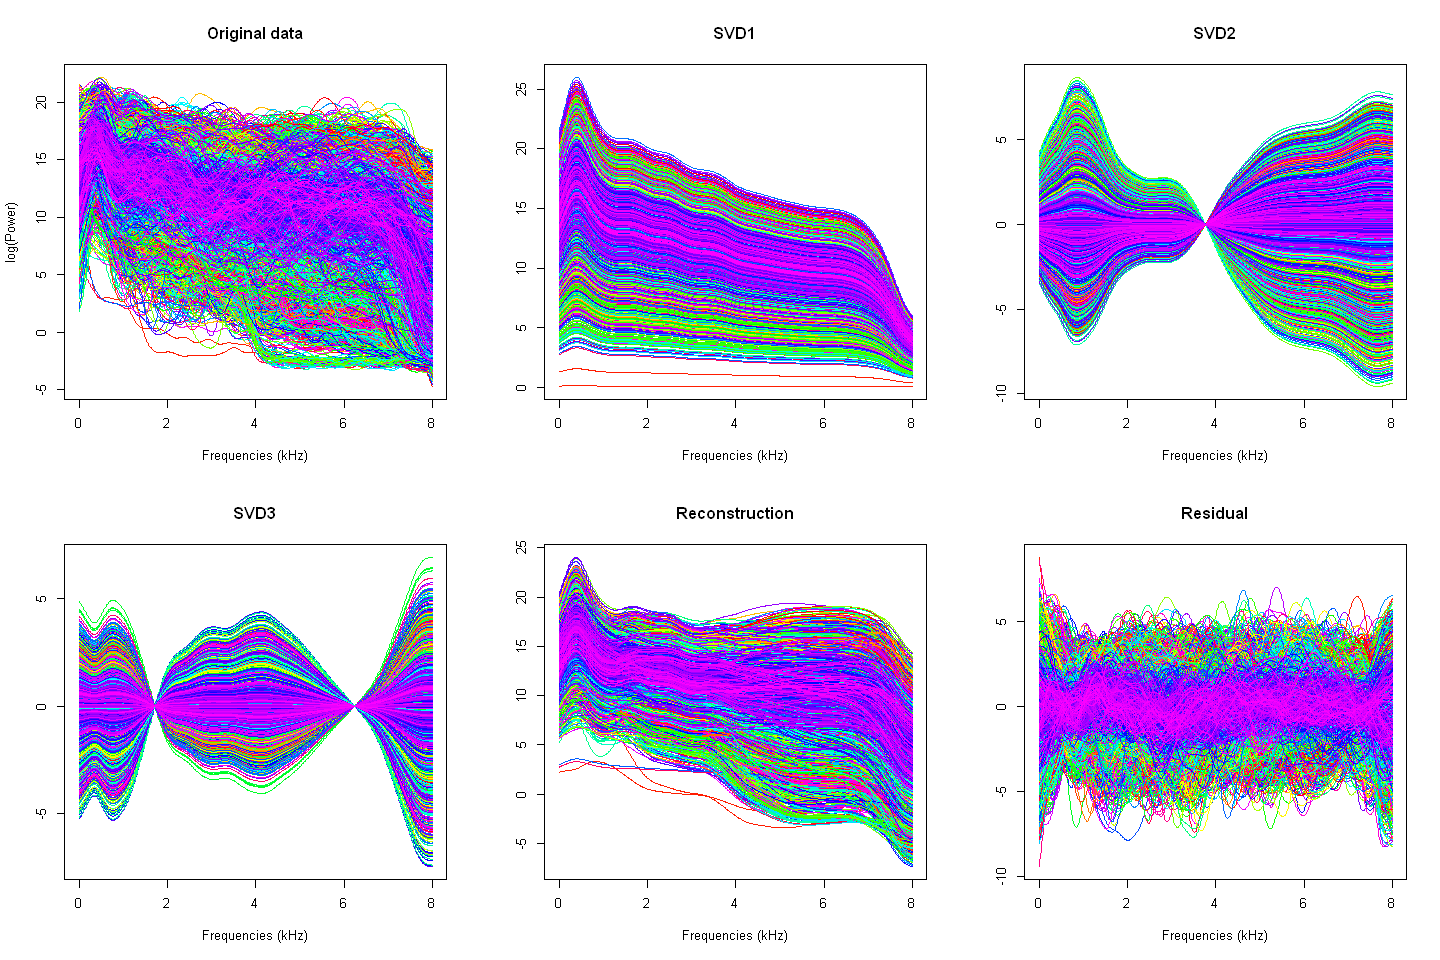

In [28]:
options(repr.plot.width = 12, repr.plot.height = 8)
train$fds <- fds(
  x = train$smooth$argvals,
  y = t(train$smooth$data),
  xname = train$data$names$xlab,
  yname = train$data$names$ylab
)
SVDplot(train$fds, order = 3)
options(repr.plot.width = 8, repr.plot.height = 8)

### fPCA

Number of PCs to explain at least 95% variance: 9 


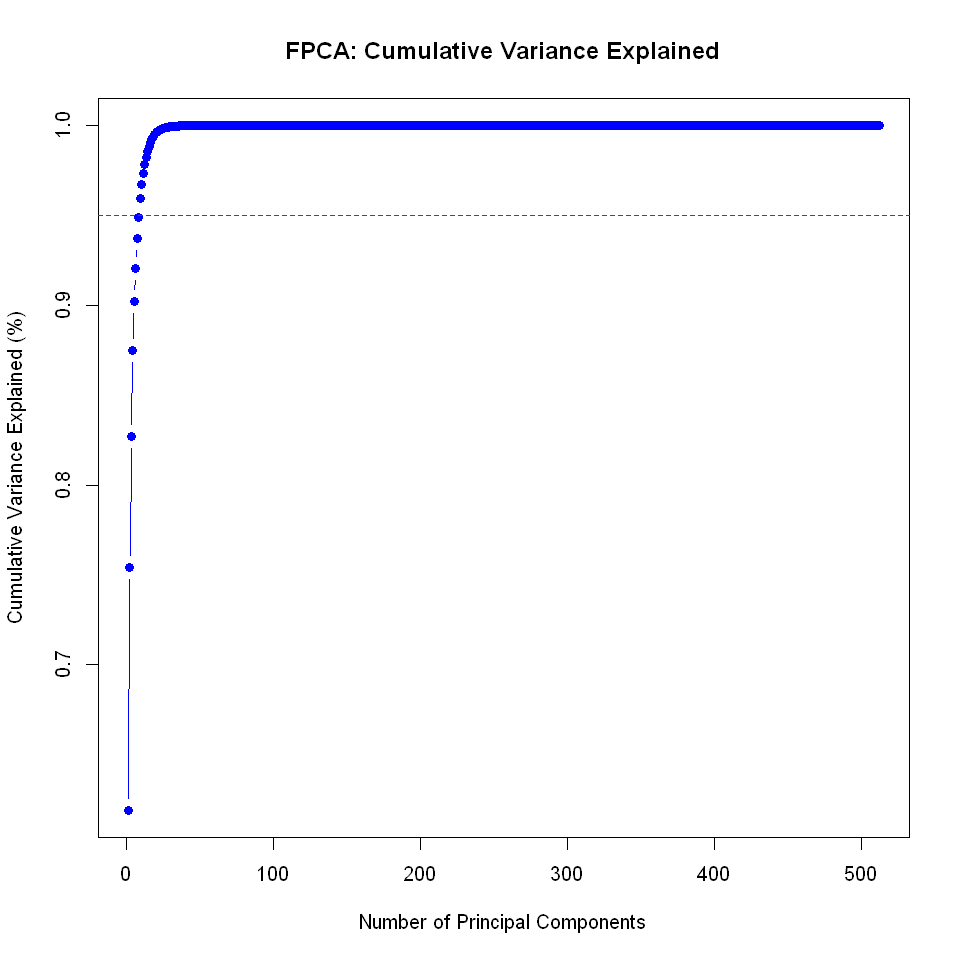

In [ ]:
ncomp <- length(train$smooth$argvals)
fpca <- fdata2pc(train$smooth, ncomp = ncomp)

explained_var <- fpca$d^2 / sum(fpca$d^2)
cum_var <- cumsum(explained_var)

# Determine how many PCs explain at least 95%
top_n <- which(cum_var >= 0.95)[1]
cat("Number of PCs to explain at least 95% variance:", top_n, "\n")

options(repr.plot.width = 8, repr.plot.height = 8)
plot(
  cum_var, type = "b", pch = 19, col = "blue",
  xlab = "Number of Principal Components",
  ylab = "Cumulative Variance Explained (%)",
  main = "FPCA: Cumulative Variance Explained"
)

abline(h = 0.95, col = "red", lty = 2)

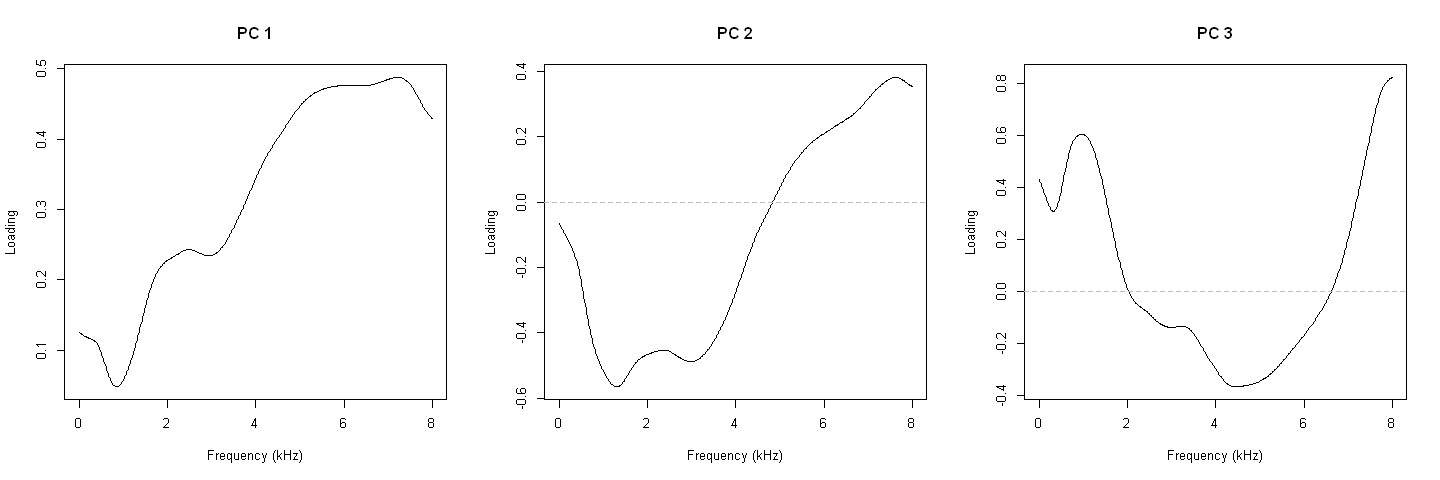

In [15]:
options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

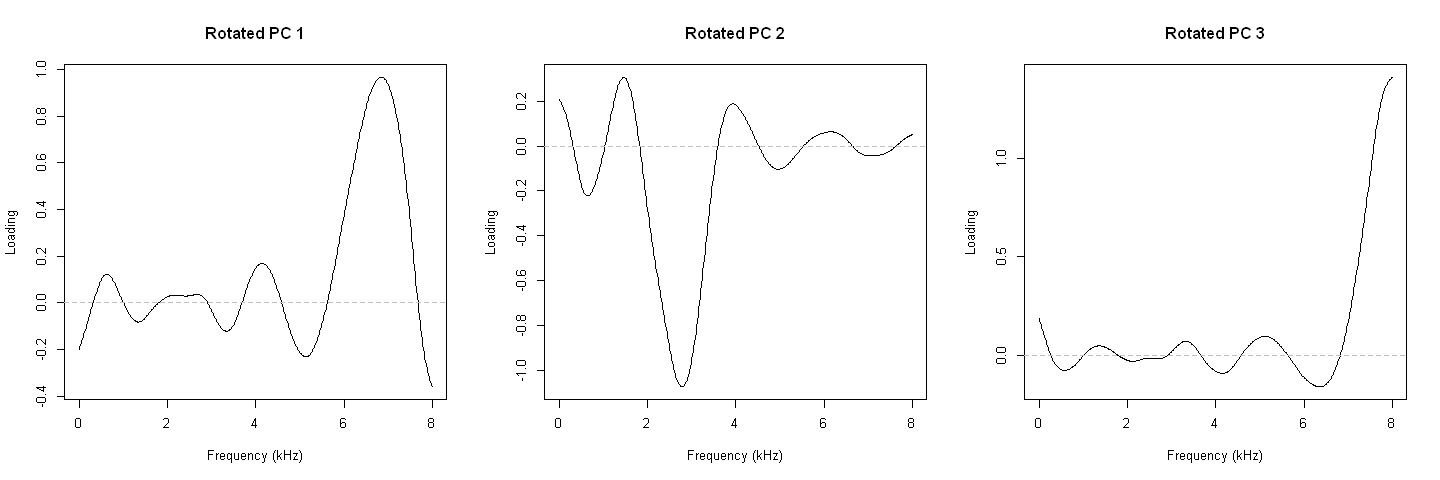

In [16]:
# Subset to top_n components
fpca$x <- fpca$x[, 1:top_n]
fpca$rotation$data <- fpca$rotation$data[1:top_n, ]

# Varimax rotation
rotated <- varimax(t(fpca$rotation$data))
fpca$rotation$data <- t(rotated$loadings)
fpca$x <- fpca$x %*% rotated$rotmat

options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("Rotated PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

PC1  explains: 61.91% variance
PC2  explains: 13.53% variance
PC3  explains:  7.24% variance
PC4  explains:  4.81% variance
PC5  explains:  2.72% variance
PC6  explains:  1.84% variance
PC7  explains:  1.65% variance
PC8  explains:  1.20% variance
PC9  explains:  1.06% variance


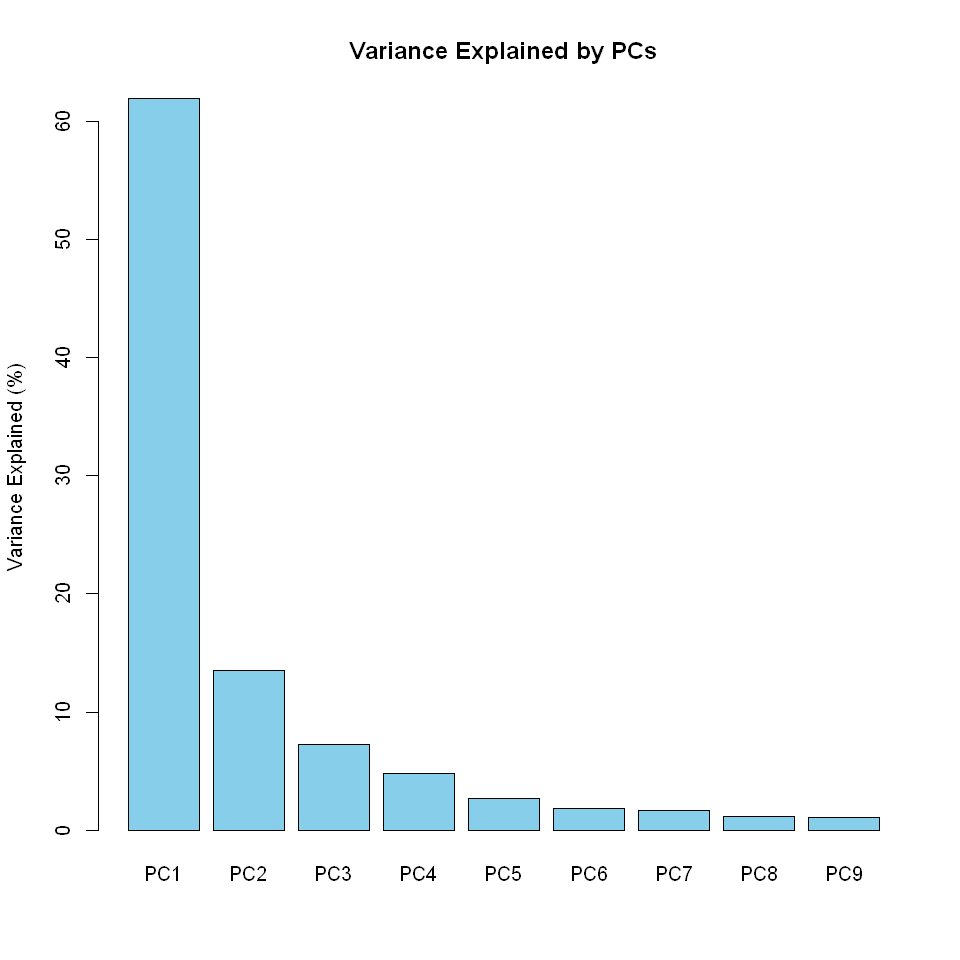

In [29]:
explained_var <- fpca$d^2 / sum(fpca$d^2)
explained_var_top <- explained_var[1:top_n]

for (i in 1:top_n) {
  cat(
    sprintf(
      "PC%-2d explains: %5.2f%% variance\n",
      i,
      explained_var_top[i] * 100
    )
  )
}

barplot(
  explained_var_top * 100,
  names.arg = paste0("PC", 1:top_n),
  ylab = "Variance Explained (%)",
  main = "Variance Explained by PCs",
  col = "skyblue"
)

### Hypothesis testing

In [ ]:
# F statistic implementation taken from Jurgita Markevičiūtė
# lecture notes on FDA hypothesis testing
twosample <- function(x, y, t.seq, alpha = 0.05) {
  if (class(x) != "fd") stop("X must be fd object")
  if (class(y) != "fd") stop("Y must be fd object")

  mu_x <- fda::mean.fd(x)
  mu_y <- fda::mean.fd(y)

  n <- dim(x$coefs)[2]
  m <- dim(y$coefs)[2]

  k <- length(t.seq)

  cn <- (n * m) / (n + m)
  delta <- (mu_x - mu_y)
  delta_t <- fda::eval.fd(t.seq, delta)

  z_x <- fda::center.fd(x)
  z_y <- fda::center.fd(y)

  z_x_t <- fda::eval.fd(t.seq, z_x)
  z_y_t <- fda::eval.fd(t.seq, z_y)
  z_t <- cbind(z_x_t, z_y_t)

  if (n > k || m > k) {
    sigma <- (t(z_t) %*% z_t) / (n - 2)
  } else {
    sigma <- (z_t %*% t(z_t)) / (n - 2)
  }

  a <- sum(diag(sigma))
  b <- sum(diag(sigma^2))

  fstat <- (cn * t(delta_t) %*% delta_t) / a
  fstat <- fstat[1]

  kappa <- a^2 / b
  pvalue <- 1 - pf(fstat, kappa, (n - 2) * kappa)
  params <- list(df1 = kappa, df2 = (n - 2) * kappa)
  return(
    list(statistics = fstat, pvalue = pvalue, params = params)
  )
}

In [ ]:
matrix_labels <- c(
  "zero", "one", "two", "three", "four",
  "five", "six", "seven", "eight", "nine"
)

# Create a matrix to store p-values
# for hypothesis tests between classes
pvalue_matrix <- matrix(NA, nrow = 10, ncol = 10)
rownames(pvalue_matrix) <- matrix_labels
colnames(pvalue_matrix) <- matrix_labels

# Convert smoothed data for each class to fd objects
fd_list <- lapply(matrix_labels, function(label) {
  fda.usc::fdata2fd(
    train$smooth[which(train$labels == label), ]
  )
})
names(fd_list) <- matrix_labels

# Perform pairwise hypothesis tests between all classes
for (i in matrix_labels) {
  for (j in matrix_labels) {
    pvalue_matrix[i, j] <- twosample(
      fd_list[[i]],
      fd_list[[j]],
      train$smooth$argvals,
      alpha = 0.05
    )$pvalue
  }
}

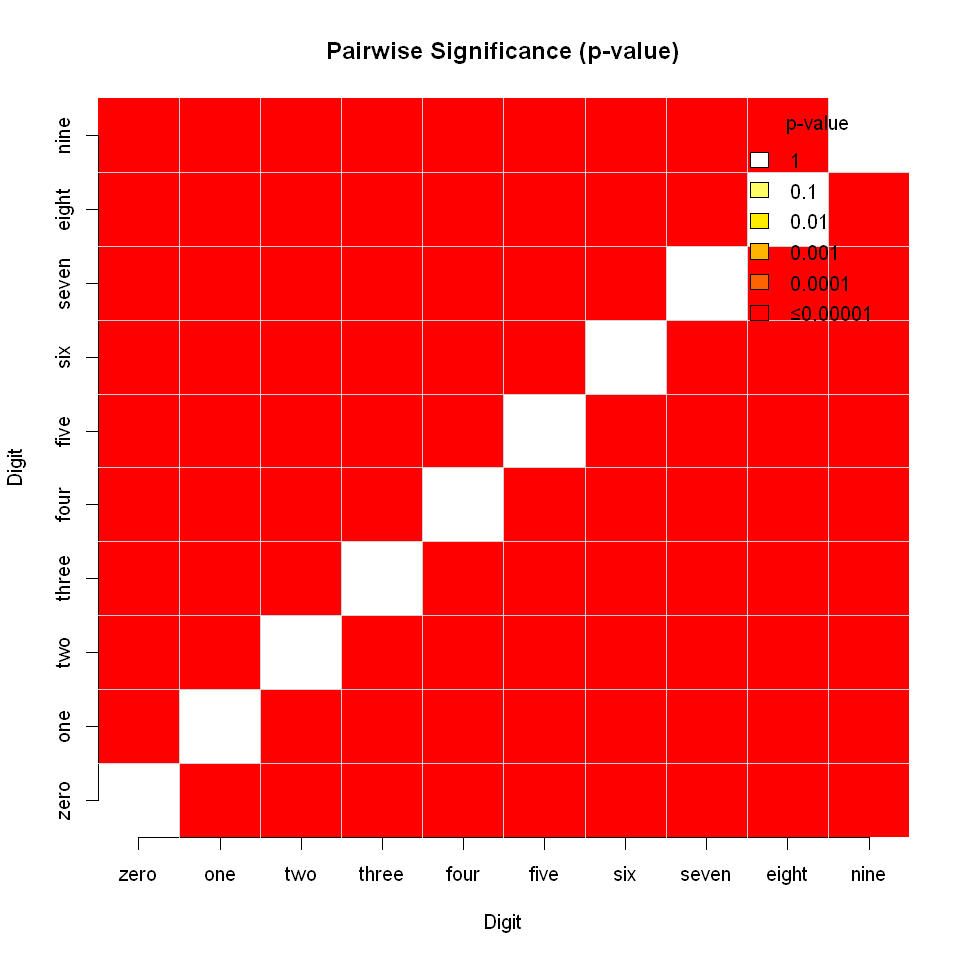

In [ ]:
log_p_matrix <- -log10(pvalue_matrix)

# Cap the maximum value to 6 for better visualization
max_val <- 6  # p-value precision, e.g. 6->0.000001
log_p_matrix[log_p_matrix > max_val] <- max_val

colors <- colorRampPalette(
  c("white", "yellow", "orange", "red")
)(6)
image(
  1:10, 1:10,
  log_p_matrix,
  col = colors,
  xlab = "Digit",
  ylab = "Digit",
  axes = FALSE,
  main = "Pairwise Significance (p-value)"
)

axis(1, at = 1:10, labels = matrix_labels)
axis(2, at = 1:10, labels = matrix_labels)
grid(nx = 10, ny = 10, col = "lightgray", lty = "solid")

legend(
  "topright",
  legend = c(
    "1", "0.1", "0.01", "0.001", "0.0001", "≤0.00001"
  ),
  fill = colors,
  title = "p-value",
  bty = "n"
)

### Classification
* Depth
* GLM
* Random Forest
* SVM
* Neural Network

In [21]:
print_metrics <- function(pred, labels) {
  cm <- caret::confusionMatrix(pred, labels)
  print(cm)

  class_stats <- cm$byClass

  macro_f1     <- mean(class_stats[, "F1"])
  macro_prec   <- mean(class_stats[, "Precision"])
  macro_recall <- mean(class_stats[, "Recall"])

  cat(sprintf("Macro Precision: %.3f\n", macro_prec))
  cat(sprintf("Macro Recall:    %.3f\n", macro_recall))
  cat(sprintf("Macro F1-score:  %.3f\n", macro_f1))

  cat("\nPer-class metrics:\n")
  print(class_stats[, c("Precision", "Recall", "F1")])
}

train_data_list <- ldata(
  "df" = data.frame(y = train$labels),
  "x"  = train$smooth
)
test_data_list <- list("x" = test$smooth)

In [22]:
depth_fit <- classif.depth(
  group = train$labels,
  fdataobj = train$data,
  newfdataobj = test$data,
  depth = "FM"
)
print_metrics(depth_fit$group.pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero   152  31  88    88   47  128  54    89    47   56
     one     33 327  86   140  217  148   4    35    88  195
     two     46  10 121    48   42    6  77    49    49    5
     three   40   5  68   113    1    6  14    12    74   34
     four    89  97  67    65  261   85  28    72    20   42
     five    18  74   4     3   38  131   5     6     0   63
     six    159  13 144    67   26   46 423   219   135   28
     seven  137  20  62    33   60   68  85   216    34   24
     eight   27  14  30    69    7   30  26     8   197   40
     nine    36  88  30    72   16   97   6    21    50  223

Overall Statistics
                                         
               Accuracy : 0.3036         
                 95% CI : (0.293, 0.3145)
    No Information Rate : 0.1045         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
    

In [23]:
glm_fit <- classif.glm(
  # formula: y is the response, x is the functional covariate
  y ~ x,
  data = train_data_list,
  family = binomial(),  # multinomial families are handled automatically
  type = "1vsall"       # multiclass
)

glm_pred <- predict(glm_fit, test_data_list)
print_metrics(glm_pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero   113  22  37    58   13   26  21    82    20   51
     one      9 224  19     6   69   68   1     7     3   69
     two     84  16 206    75   41    4  48    49    79   15
     three   55   7  89   258    7   11  44    25   122   81
     four    50 174  68    12  455  107   4    82     5   49
     five    73 123   6     7   79  375   3    50     0   95
     six     74   3  92    39    6    1 467    78    53    3
     seven  179  19  33    12   35   46  67   315    10   24
     eight   30   0 119   140    1    0  50     3   390   13
     nine    70  91  31    91    9  107  17    36    12  310

Overall Statistics
                                          
               Accuracy : 0.4368          
                 95% CI : (0.4252, 0.4484)
    No Information Rate : 0.1045          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [24]:
rf_fit <- classif.randomForest(
  y ~ x,
  data  = train_data_list,
  ntree = 150,
)
rf_pred <- predict(rf_fit, test_data_list)
print_metrics(rf_pred, test$labels)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero   145  22  60    47   32   39  61   143    31   33
     one     20 218  31    28   98   74   3    16    10  100
     two     50  11 161    62   28    4  70    43    81   11
     three   55  10  74   206    5   11  24    23   141   59
     four    48 125  54    25  373   85   3    51     7   26
     five   112 174  20    33  102  392   4    67     1  176
     six     59   0  98    31    8    3 397    92    72    5
     seven  163  17  50    39   45   38  94   251    13   20
     eight   31   2 110   102    4    0  58     7   299    8
     nine    54 100  42   125   20   99   8    34    39  272

Overall Statistics
                                          
               Accuracy : 0.3808          
                 95% CI : (0.3695, 0.3922)
    No Information Rate : 0.1045          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [25]:
svm_fit <- classif.svm(y ~ x, data = train_data_list)
svm_pred <- predict(svm_fit, test_data_list)
print_metrics(svm_pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero   171  78  71    84   53   88  85   177    45   98
     one      4 215  15     7   74   45   2     9     7   74
     two    270 121 359   289  117   98 166   187   185  157
     three    6   3  22    72    2    5   9     3    24   19
     four    23  96  35    11  344   49   0    34     0   13
     five    94 147   9    14   87  410   7    63     1  140
     six     26   0  42    12    2    0 323    27    28    0
     seven   85   6  12     7   32   14  64   206     5    4
     eight   27   0 115   134    2    0  54     3   380    7
     nine    31  13  20    68    2   36  12    18    19  198

Overall Statistics
                                          
               Accuracy : 0.3758          
                 95% CI : (0.3645, 0.3871)
    No Information Rate : 0.1045          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [ ]:
nnet_fit <- classif.nnet(
  y ~ x,
  data = train_data_list,
  size = 10,
  maxit = 100
)
nnet_pred <- predict(nnet_fit, test_data_list)
print_metrics(nnet_pred, test$labels)

# weights:  190
initial  value 74626.437861 
iter  10 value 54066.777621
iter  20 value 49035.195671
iter  30 value 46782.115628
iter  40 value 45948.187894
iter  50 value 45208.440903
iter  60 value 44760.461938
iter  70 value 44306.199387
iter  80 value 44090.286806
iter  90 value 43883.236354
iter 100 value 43694.237287
final  value 43694.237287 
stopped after 100 iterations
Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    90  11  35    45    6   14  24    74    18   37
     one     13 298  43    20  161  100   1    16     5   99
     two     59   7 157    59   20    1  50    33    95    5
     three   42   4  77   242    0    2  21    13   129   52
     four    48 110  63    11  350   62   2    58     4   24
     five   122 174  13    13  111  451   8    72     0  164
     six     64   1 103    42    5    0 435    52    67    2
     seven  204  11  61    21   50   31 118   366    17   17
     eight   20  